In [415]:
import json
import sys
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read input.json and open locally
f = open('input.json')
data = json.load(f)
data = pd.DataFrame(data)
f.close()
    



In [416]:
import nltk

#strip html tags from description column with nltk
def clean_text(text):
    clean_tags_re = re.compile(r'<[^>]+?>')
    no_tags = clean_tags_re.sub('', text)
    #strip newlines and tabs
    return re.sub(r'[\n\t]', '', no_tags)


#apply strip_html_tags to description column
data['description_cleaned'] = data['description'].apply(clean_text)


In [417]:
categories = ["TOPS", 
"DRESS", 
"PANT", 
"SKIRT", 
"SHORTS", 
"LINGERIE", 
"OUTERWEAR", 
"JUMPSUIT", 
"JEWELRY", 
"BAG", 
"SHOE", 
"OTHERS"]


In [420]:
#Make subcatgories
#I created this without looking at the actual data to avoid overfitting
#I looked at various online retailers to see how they split the categories
augment_categories= ["shirt, shirts, t-shirt, tee, tanktop, bikini, swimsuit, long sleeve shirt, short sleeve shirt,  tank, button down, dress shirt, polo shirt, sleeveless shirt, turtleneck, oxford, crew neck, sweater, v-neck, tube top, blouse",
                     "dress, dresses, evening dress, cocktail dress, casual dress, strapless dress, gown",
                     "pant, pants, jeans, trousers, high waisted, cargo, work out, leggings, joggers, sweatpants, cropped, bell bottom",
                     "skirt, skirts, mini skirt",
                     "shorts, bermuda shorts, workout shorts, high waisted shorts, cycling shorts, biker shorts, board shorts, capri, booty short",
                     "lingerie, bra, panties, bustier, bralette, robe, corsette, underwear, thong",
                     "outerwear, jacket, blazer, vest, trench coat, top coat, pea coat, rain coat, fleece, windbreaker, hoodie, poncho, bomber jacket",
                     "jumpsuit",
                     "jewelry, watch, wrist watch, bracelet, necklace, ring, earring, ear ring, pendant, brooch, anklet, choker, cuff, charm bracelet",
                     "bag, purse, tote, handbag, backpack, clutch, satchel, messenger bag, hobo bag, fanny pack, briefcase, over the shoulder, laptop bag",
                     "shoe, shoes, sneakers, sandal, boot, loafter, ballet flat, mule, oxford, platform, pump, heel, wedge, flip flop, clog, moccasin",
                     "other, miscellaneous, scarf, belt, gloves, handkerchief, sunglasses, hat, eyewear, umbrella, headband, wallet"]

In [421]:
#find all rows where one of the categories is in the description column
data[data['description'].apply(lambda x: True if any(c.lower() in x for c in categories) else False)]
#71 rows ostensibly with (potentially) correct labels 
#Can maybe use to bootstrap a model

,image_url,description,description_cleaned
36,https://cdn.theyes.com/images/full/48e050df84a...,\n\n\n<p>The Alice bag is made from calf leath...,The Alice bag is made from calf leather and is...
55,https://cdn.theyes.com/images/full/d2129d5bcad...,\n<p>Our Louise Dress is a one shoulder dress ...,Our Louise Dress is a one shoulder dress in gr...
71,https://cdn.theyes.com/images/full/bfb913c4a02...,\n\n\n<p>The Edie bag is made from calf leathe...,The Edie bag is made from calf leather and is ...
79,https://cdn.theyes.com/images/full/d8c51475735...,\n<p><span>The Theia</span><span> is held toge...,The Theia is held together with a gold central...
83,https://cdn.theyes.com/images/full/3f874581218...,\n<p><span>You’re victorious in our V Short—a ...,You’re victorious in our V Short—a cutoff vers...
...,...,...,...
940,https://cdn.theyes.com/images/full/b93a94fa52d...,The Bailey 44 Santorini Skirt<span> is a full ...,The Bailey 44 Santorini Skirt is a full length...
946,https://cdn.theyes.com/images/full/a862898b91d...,"\n<p>We love this lightweight, cropped cardiga...","We love this lightweight, cropped cardigan pai..."
968,https://cdn.theyes.com/images/full/57d61f1f7f5...,Carnation print Three-quarter sleeves with but...,Carnation print Three-quarter sleeves with but...
979,https://cdn.theyes.com/images/full/c10729eccc5...,\n\n<p>Our Boom pant is the perfect way to add...,Our Boom pant is the perfect way to add flare ...


In [422]:
#make column with total count of each category in description column
data['category_count'] = data['description'].apply(lambda x: len([c for c in categories if c.lower() in x]))
#select rows with category count > 0
bad_labels = data[data['category_count'] > 1]
#first one is a dress, but says you can pair with a (bag)
#second one is a sweatshirt but says to pair with (skirt) or sweat(pant)s
bad_labels

,image_url,description,description_cleaned,category_count
349,https://cdn.theyes.com/images/full/385569efd85...,"\n\n<p>The bow detailing, and long sleeves are...","The bow detailing, and long sleeves are what m...",2
930,https://cdn.theyes.com/images/full/9cb0bc9d858...,\n<p>We added pleat sleeves to a classic sweat...,We added pleat sleeves to a classic sweatshirt...,2


In [423]:
#make column with which category appears in description column if it exists, otherwise empty string
data['category'] = data['description'].apply(lambda x: [c for c in categories if c.lower() in x][0] if len([c for c in categories if c.lower() in x]) > 0 else '')


In [424]:
#set index 930 category column to be tops (is a sweatshirt a top?)
data.loc[930, 'category'] = 'TOPS'

#drop category_count column
data = data.drop(columns=['category_count', 'description'])

In [425]:
test_data = data[data['category'] != '']

In [428]:
many_cats = []
for cat in augment_categories:
  many_cats += [x.strip() for x in cat.split(',')]



In [429]:
reverse_lookup_dict = {}
for ind, category in enumerate(categories):
  for specific_item in [x.strip() for x in augment_categories[ind].split(',')]:
    reverse_lookup_dict[specific_item] = category

In [430]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_image_probs(url, image, categories):
  aug_categories = ["a photo of " + categories[x] for x in range(len(categories))]
  inputs = processor(text=aug_categories, images=image, return_tensors="pt", padding=True)
  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image 
  probs = logits_per_image.softmax(dim=1) 
  return [x for x in zip(categories,probs.detach().numpy()[0])]

def get_aggregated_probs(probs):
  output = {category:0 for category in categories}
  for specific_item, prob in probs:
    output[reverse_lookup_dict[specific_item]] += prob
    #TODO: having different number of subclasses might lead to overweighting those with more subclasses?
    #The less sure the model is (the more it assigns weight uniformly), the more this will happen
    #Can maybe divide the sum by the count of subclasses and then reweight at the end so it sums to 1?
    #Don't have enough time to test this.
  return sorted(output.items(), key = lambda x: x[0])

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


# Debug

In [436]:
ind = 571
url = data.iloc[ind]['image_url']
description = data.iloc[ind]['description_cleaned']
image = Image.open(requests.get(url, stream=True).raw)
img = image.convert('RGB')
probs = get_image_probs(url, img, many_cats)
aggregated_probs = get_aggregated_probs(probs)

In [437]:
description

'Mini skirt, Flared design, Checkered print, Inner lining, Concealed zip fastening on the back'

In [438]:
sorted(probs, key = lambda x:-x[1])

[('jacket', 0.20765652),
 ('dress shirt', 0.18821599),
 ('button down', 0.09616598),
 ('outerwear', 0.08964356),
 ('bomber jacket', 0.07578781),
 ('trench coat', 0.04398015),
 ('pea coat', 0.037496794),
 ('blouse', 0.032213226),
 ('casual dress', 0.031916488),
 ('windbreaker', 0.030886823),
 ('rain coat', 0.019325936),
 ('long sleeve shirt', 0.015961917),
 ('top coat', 0.0154306255),
 ('skirt', 0.010804351),
 ('blazer', 0.008182413),
 ('dress', 0.007538352),
 ('cocktail dress', 0.0071466495),
 ('trousers', 0.0057050376),
 ('sweater', 0.005653702),
 ('vest', 0.004410143),
 ('mini skirt', 0.0043457714),
 ('fleece', 0.004165321),
 ('shirt', 0.0036788993),
 ('short sleeve shirt', 0.0034700618),
 ('bermuda shorts', 0.0032628695),
 ('robe', 0.0029767526),
 ('over the shoulder', 0.0027901137),
 ('joggers', 0.0027652767),
 ('turtleneck', 0.0025262265),
 ('gown', 0.002239654),
 ('shorts', 0.0020165972),
 ('high waisted', 0.0019950315),
 ('skirts', 0.0018945588),
 ('booty short', 0.0017342591),


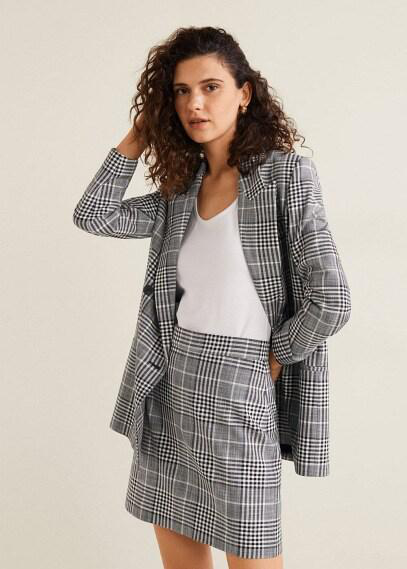

In [439]:
image

In [440]:
aggregated_probs

[('BAG', 0.00430843288700089),
 ('DRESS', 0.04986739595187828),
 ('JEWELRY', 0.001300045304788),
 ('JUMPSUIT', 1.0311928235751111e-05),
 ('LINGERIE', 0.005076690671558026),
 ('OTHERS', 0.002798647287818312),
 ('OUTERWEAR', 0.5372388376999879),
 ('PANT', 0.016152385512214096),
 ('SHOE', 0.002036497088511169),
 ('SHORTS', 0.010751829417131376),
 ('SKIRT', 0.01704468159005046),
 ('TOPS', 0.3534142560165492)]

 # CLIP

In [ ]:
image_output = []
#TODO: do this in parallel 
for ind in range(len(data)):
  print(ind)
  url = data.iloc[ind]['image_url']
  description = data.iloc[ind]['description_cleaned']
  image = Image.open(requests.get(url, stream=True).raw)
  img = image.convert('RGB')
  probs = get_image_probs(url, img, many_cats)
  aggregated_probs = get_aggregated_probs(probs)
  image_output.append(aggregated_probs)

In [137]:
out = []
for x in image_output:
  out.append([y[1] for y in x])

In [139]:
image_output_df = pd.DataFrame(out, columns=[x[0] for x in raw[0]])
image_output['max_prob'] = image_output.max(axis=1)
image_output['predicted_category'] = image_output.idxmax(axis=1)
image_output.to_csv('image_output.csv')


In [332]:
image_output = pd.read_csv('image_output.csv',index_col=0)

In [166]:
test_set = test_data.join(image_output)

In [168]:
len(test_set[test_set['category'] == test_set['predicted_category']]) / len(test_set)
#By looking through this by hand, it seems like this value of .55 is low 
#There are examples where the self-describing description is wrong, and the image prediciton is right

0.5492957746478874

In [170]:
test_set[test_set['category'] != test_set['predicted_category']]

,image_url,description_cleaned,category,BAG,DRESS,JEWELRY,JUMPSUIT,LINGERIE,OTHERS,OUTERWEAR,PANT,SHOE,SHORTS,SKIRT,TOPS,max_prob,predicted_category
83,https://cdn.theyes.com/images/full/3f874581218...,You’re victorious in our V Short—a cutoff vers...,SHORTS,0.002059,0.002367,0.000094,9.897781e-05,0.681926,0.000733,0.001988,0.104965,0.000621,0.178151,0.008061,0.018937,0.681926,LINGERIE
101,https://cdn.theyes.com/images/full/5c6fcc27f99...,"Do not rub, soak or wring. Dry in the shade. ...",BAG,0.010404,0.035030,0.004312,3.851763e-05,0.667482,0.002399,0.003533,0.011208,0.001116,0.002734,0.002565,0.259179,0.667482,LINGERIE
111,https://cdn.theyes.com/images/full/c366c96cff0...,The Pietra Heel is a leather strappy heel in w...,BAG,0.006945,0.005714,0.131195,7.519907e-07,0.015234,0.008058,0.007292,0.004124,0.804585,0.000848,0.002887,0.013117,0.804585,SHOE
112,https://cdn.theyes.com/images/full/e8af61715ac...,Long button down dress with concealed button p...,DRESS,0.003092,0.200513,0.002351,3.733261e-03,0.022140,0.005392,0.639883,0.041754,0.012503,0.007299,0.010154,0.051185,0.639883,OUTERWEAR
153,https://cdn.theyes.com/images/full/375382e0626...,The Shirley Bag is a classic structured tote m...,BAG,0.087722,0.082937,0.001803,6.671658e-07,0.021382,0.001922,0.007181,0.005088,0.005581,0.003289,0.766478,0.016615,0.766478,SKIRT
193,https://cdn.theyes.com/images/full/cfc8fc03ee0...,calf leather Double leather handle that allows...,BAG,0.105809,0.193075,0.002281,7.887291e-05,0.016941,0.008391,0.518468,0.006675,0.006283,0.009242,0.058332,0.074422,0.518468,OUTERWEAR
197,https://cdn.theyes.com/images/full/bbd75b75c24...,"Distinctive details - contrast topstitching, a...",TOPS,0.004997,0.015236,0.005670,1.560752e-04,0.015994,0.012866,0.244034,0.514773,0.013194,0.036518,0.028161,0.108401,0.514773,PANT
218,https://cdn.theyes.com/images/full/bca9eb9aada...,The Angelou bag features an acrylic round hand...,BAG,0.042391,0.077590,0.720787,1.109518e-04,0.021425,0.048120,0.006862,0.006819,0.029770,0.001445,0.003145,0.041536,0.720787,JEWELRY
249,https://cdn.theyes.com/images/full/efd68159b5f...,"Short design, Flared design, Full skirt, Dart ...",SKIRT,0.001187,0.803844,0.007868,2.468107e-05,0.004372,0.002120,0.007544,0.001874,0.001635,0.002178,0.045169,0.122184,0.803844,DRESS
254,https://cdn.theyes.com/images/full/95d2598c124...,Collar with button Front button closure Roses ...,SKIRT,0.002216,0.616648,0.001623,2.779739e-05,0.005203,0.003365,0.226124,0.004610,0.004147,0.003235,0.094319,0.038481,0.616648,DRESS


# MiniLM

In [362]:
#Bootstrap the descriptions by using very confident image predictions
#Use these to compare new descriptions for the more ambiguous cases
threshold = .8
unambiguous = image_output[image_output.iloc[: , :-2].apply(lambda x: True if sum(x >= threshold) == 1 else False, axis=1)]
unambiguous_set = unambiguous.join(data)

In [363]:
unambiguous_descriptions = unambiguous_set.groupby(['predicted_category'])['description_cleaned'].apply(','.join).reset_index()


In [ ]:
unambiguous_descriptions.append(
    {'predicted_category': 'JUMPSUIT', 'description_cleaned':'jumpsuit'},
     ignore_index=True).sort_values(by='predicted_category').reset_index(drop=True)

In [364]:
ambiguous = image_output[image_output.iloc[: , :-2].apply(lambda x: True if sum(x > threshold) == 0 else False, axis=1)]

In [365]:
ambiguous_set = ambiguous.join(data)

In [366]:
from transformers import AutoTokenizer, AutoModel
from torch.nn import functional as F
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

sentence_embs = model.encode(data['description_cleaned'])
label_embs = model.encode(unambiguous_descriptions['description_cleaned'])

from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(sentence_embs, label_embs)


In [367]:
norm_similarities = similarities / similarities.sum(axis=1, keepdims=True)


In [368]:
updated_probs = image_output[unambiguous_descriptions['predicted_category']] * norm_similarities

In [369]:
updated_probs = updated_probs.div(updated_probs.sum(axis=1), axis=0)

In [370]:
updated_probs['max_prob'] = updated_probs.max(axis=1)
updated_probs['predicted_category'] = updated_probs.idxmax(axis=1)

In [371]:
updated_output = data.join(updated_probs)

In [372]:
updated_output[image_output['predicted_category'] != updated_output['predicted_category']]

,image_url,description_cleaned,category,BAG,DRESS,JEWELRY,LINGERIE,OTHERS,OUTERWEAR,PANT,SHOE,SKIRT,TOPS,max_prob,predicted_category
0,https://cdn.theyes.com/images/full/5a05c6a7540...,"Nylon, brushed leather Two leather handles Det...",,0.184284,0.098427,0.002072,0.005382,0.004337,0.272497,0.227592,0.006728,0.017192,0.181490,0.272497,OUTERWEAR
9,https://cdn.theyes.com/images/full/5533feb0dab...,Metal Gold-tone or silver-tone finish,,0.119468,0.006619,0.279969,0.033315,0.028925,0.085163,0.086337,0.270226,0.006777,0.083201,0.279969,JEWELRY
11,https://cdn.theyes.com/images/full/94ca7ad9716...,Belt loops Zipper fly with hook and loop faste...,,0.003264,0.108267,0.002147,0.029499,0.007430,0.282145,0.279084,0.008814,0.041038,0.238314,0.282145,OUTERWEAR
21,https://cdn.theyes.com/images/full/960ec60c4ef...,"Our newest hoodie, in super soft Portuguese co...",,0.000443,0.000699,0.000286,0.000979,0.000555,0.389791,0.010476,0.000344,0.000135,0.596293,0.596293,TOPS
32,https://cdn.theyes.com/images/full/db6ff6ce8aa...,Nylon Calf leather trim Adjustable leather sho...,,0.014750,0.118647,0.003323,0.010176,0.009850,0.405498,0.049959,0.020581,0.353018,0.014199,0.405498,OUTERWEAR
37,https://cdn.theyes.com/images/full/e373d0e1696...,,,0.021202,-0.953576,0.005898,0.255769,0.001095,0.016665,0.043672,0.007702,1.225391,0.376182,1.225391,SKIRT
44,https://cdn.theyes.com/images/full/f104eed4187...,Metal Gold-tone or silver-tone finish,,0.035329,0.003226,0.361997,0.071602,0.037709,0.088838,0.126085,0.075230,0.010425,0.189559,0.361997,JEWELRY
62,https://cdn.theyes.com/images/full/4a0a60feec5...,"Straw fabric, Decorative bow",,0.057809,0.020161,0.052943,0.227958,0.214231,0.080201,0.033852,0.049258,0.017134,0.246451,0.246451,TOPS
89,https://cdn.theyes.com/images/full/5225e54fa1c...,"Recycled cotton-blend fabric, Open knit fabric...",,0.013650,0.043641,0.003103,0.058024,0.003142,0.007121,0.087598,0.000835,0.339607,0.443281,0.443281,TOPS
113,https://cdn.theyes.com/images/full/476111bc257...,Madras goat leather Flap closure with leather ...,,0.063687,0.317388,0.021799,0.057324,0.026293,0.024847,0.026042,0.031024,0.121920,0.309675,0.317388,DRESS


In [373]:
len(updated_output[image_output['predicted_category'] != updated_output['predicted_category']])

59

In [344]:
updated_output.to_csv('updated_output.csv')

In [346]:
#read in updated_output.csv
updated_output = pd.read_csv('updated_output.csv',index_col=0)
f = open('input.json')
out_data = json.load(f)
out_data = pd.DataFrame(out_data)
out_data['category'] = updated_output['predicted_category']
#write data to updated_input.json
with open('output.json', 'w') as f:
    json.dump(out_data.to_dict(orient='records'), f)

